# 3. Foursquare APIを使用して、レストランの位置情報を取得してみよう

### IDとシークレットを取得
 - 以下のサイトでアプリを作る必要がある
 - https://ja.foursquare.com/developers/apps

In [1]:
import pandas as pd

# Foursquare API version
VERSION = '20190325'

# FourSquareのIDと鍵情報を取り出す
sec = pd.read_csv('sec.csv', header=None)

CLIENT_ID = sec.loc[0,1]
CLIENT_SECRET = sec.loc[1,1]

In [2]:
import requests

radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [3]:
import pandas as pd
df = pd.read_csv('tokyo.csv')

In [4]:
df

,Unnamed: 0,name,population,dence,area,major_district,latitude,longitude
0,0,Chiyoda,"59,441","5,100",11.66,Nagatachō,35.675618,139.743469
1,1,Chūō,"147,620","14,460",10.21,Nihonbashi,35.684058,139.774501
2,2,Minato,"248,071","12,180",20.37,Odaiba,35.619128,139.779403
3,3,Shinjuku,"339,211","18,620",18.22,Shinjuku,35.693763,139.703632
4,4,Bunkyō,"223,389","19,790",11.29,Hongō,35.175386,137.013430
5,5,Taitō,"200,486","19,830",10.11,Ueno,35.711788,139.776096
6,6,Sumida,"260,358","18,910",13.77,Kinshichō,35.696752,139.814151
7,7,Kōtō,"502,579","12,510",40.16,Kiba,23.013134,-80.832875
8,8,Shinagawa,"392,492","17,180",22.84,Shinagawa,35.599252,139.738910
9,9,Meguro,"280,283","19,110",14.67,Meguro,35.621250,139.688014


### 23区の中で調べてみたい5つを指定して取り出す

In [5]:
ward_list = ['Chiyoda', 'Minato', 'Shinjuku', 'Shibuya', 'Shinagawa']
df_selected = df.loc[df['name'].isin(ward_list)]
df_selected

,Unnamed: 0,name,population,dence,area,major_district,latitude,longitude
0,0,Chiyoda,"59,441","5,100",11.66,Nagatachō,35.675618,139.743469
2,2,Minato,"248,071","12,180",20.37,Odaiba,35.619128,139.779403
3,3,Shinjuku,"339,211","18,620",18.22,Shinjuku,35.693763,139.703632
8,8,Shinagawa,"392,492","17,180",22.84,Shinagawa,35.599252,139.738910
12,12,Shibuya,"227,850","15,080",15.11,Shibuya,35.664596,139.698711


### ５つの主要都市の近隣情報を取得する
 - 地区名、緯度、経度を渡す
 - FourSquare APIを使用する

In [6]:
venues = getNearbyVenues(names=df_selected["name"],
                                   latitudes=df_selected["latitude"],
                                   longitudes=df_selected["longitude"]
                                  )
venues.shape

Chiyoda
Minato
Shinjuku
Shinagawa
Shibuya


(493, 7)

### レストランの情報だけを抽出する
 - VenueCategoryにRestaurantの文字列が含まれるものを抽出

In [7]:
only_restaurant = venues[venues['Venue_Category'].str.contains('Restaurant')].reset_index(drop=True)
print ("レストランの数: ", only_restaurant.shape)
only_restaurant.head(10)

レストランの数:  (155, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Chiyoda,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Chiyoda,35.675618,139.743469,Star Hill (星ヶ岡),35.673953,139.740998,Chinese Restaurant
2,Chiyoda,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
3,Chiyoda,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant
4,Chiyoda,35.675618,139.743469,Akasaka Fukinuki (赤坂ふきぬき),35.673257,139.738332,Unagi Restaurant
5,Chiyoda,35.675618,139.743469,Kisurin (希須林),35.674514,139.737969,Ramen Restaurant
6,Chiyoda,35.675618,139.743469,Szechwan Restaurant (赤坂 四川飯店),35.679494,139.739353,Szechuan Restaurant
7,Chiyoda,35.675618,139.743469,Tonkatsu Masamune (とんかつ まさむね),35.672068,139.740000,Tonkatsu Restaurant
8,Chiyoda,35.675618,139.743469,白銀屋 溜池山王分店,35.671290,139.741028,Japanese Restaurant
9,Chiyoda,35.675618,139.743469,Tinun (ティーヌン),35.673732,139.738345,Thai Restaurant


In [8]:
only_restaurant.to_csv("tokyo_rest.csv")

# 4. foliumを使って地図上にレストランの場所を可視化してみよう

### 東京の地図を表示するために東京の緯度と経度を取得する
 - geopyを使う

In [9]:
from geopy.geocoders import Nominatim
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('東京の緯度と経度は、{}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

東京の緯度と経度は、35.6828387, 139.7594549.


### 地域の場所を地図上に可視化 
 - foliumを以下のコマンドでインストール
 - "conda install -c conda-forge folium"

In [10]:
import folium

Tokyo_map = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# 5都市の場所をマーキング
for lat, lng, label in zip(df_selected['latitude'], df_selected['longitude'], 
                           df_selected['major_district']):    
    folium.Marker(location=[lat, lng], popup=label).add_to(Tokyo_map)

Tokyo_map

In [11]:
only_restaurant

,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Chiyoda,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Chiyoda,35.675618,139.743469,Star Hill (星ヶ岡),35.673953,139.740998,Chinese Restaurant
2,Chiyoda,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
3,Chiyoda,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant
4,Chiyoda,35.675618,139.743469,Akasaka Fukinuki (赤坂ふきぬき),35.673257,139.738332,Unagi Restaurant
5,Chiyoda,35.675618,139.743469,Kisurin (希須林),35.674514,139.737969,Ramen Restaurant
6,Chiyoda,35.675618,139.743469,Szechwan Restaurant (赤坂 四川飯店),35.679494,139.739353,Szechuan Restaurant
7,Chiyoda,35.675618,139.743469,Tonkatsu Masamune (とんかつ まさむね),35.672068,139.740000,Tonkatsu Restaurant
8,Chiyoda,35.675618,139.743469,白銀屋 溜池山王分店,35.671290,139.741028,Japanese Restaurant
9,Chiyoda,35.675618,139.743469,Tinun (ティーヌン),35.673732,139.738345,Thai Restaurant


In [12]:
df2 = only_restaurant[only_restaurant["District"] == "Shibuya"]

In [13]:
r_map = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=12)

# レストランの場所を地図上にプロット
for lat, lng, label in zip(df2['Venue_Lat'], df2['Venue_Long'], 
                           df2['Venue']):    
    folium.Marker(location=[lat, lng], popup=label).add_to(r_map)

r_map

# 5. 取得したデータを分析してみよう
 - 5都市で人が頻繁に訪れる場所
 - 5都市それぞれのレストランの数

In [14]:
print(venues["Venue_Category"].value_counts())

Ramen Restaurant             26
Convenience Store            25
Sake Bar                     22
BBQ Joint                    19
Café                         18
Coffee Shop                  18
Japanese Restaurant          17
Bar                          15
Chinese Restaurant           13
Hotel                        12
Sushi Restaurant             11
Yakitori Restaurant           9
Record Shop                   9
Dessert Shop                  7
Soba Restaurant               7
French Restaurant             6
Intersection                  6
Bookstore                     6
Plaza                         6
Seafood Restaurant            6
Park                          6
Rock Club                     5
Donburi Restaurant            5
Italian Restaurant            5
Tonkatsu Restaurant           5
Pub                           5
Restaurant                    5
Shopping Mall                 4
Japanese Curry Restaurant     4
Clothing Store                4
                             ..
Candy St

In [15]:
# create a dataframe of top 10 categories
Top10 = venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Top10 = Top10.reset_index()

Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Top10

,Venue_Category,Frequency
0,Ramen Restaurant,26
1,Convenience Store,25
2,Sake Bar,22
3,BBQ Joint,19
4,Café,18
5,Coffee Shop,18
6,Japanese Restaurant,17
7,Bar,15
8,Chinese Restaurant,13
9,Hotel,12


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 5 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

<Figure size 1800x700 with 1 Axes>

In [17]:
number_of_restaurant = only_restaurant["District"].value_counts().to_frame(name='frequency')
number_of_restaurant = number_of_restaurant.reset_index()
number_of_restaurant.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
number_of_restaurant

,Venue_Category,Frequency
0,Chiyoda,50
1,Shinagawa,36
2,Shibuya,30
3,Shinjuku,28
4,Minato,11


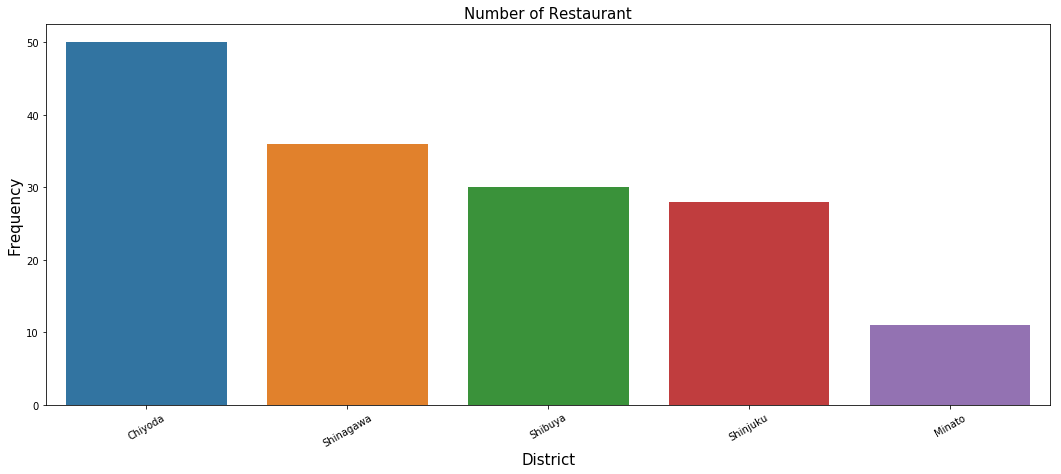

In [18]:
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=number_of_restaurant)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Number of Restaurant', fontsize=15)
plt.xlabel("District", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Number_of_Restaurant.png", dpi=300)
plt.show()